In [54]:
import warnings
warnings.filterwarnings("ignore")
import prepare as p
import model as m
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing
np.random.seed(0)

# evaluate
from sklearn.metrics import mean_squared_error
from math import sqrt 

## Exercises

The end result of this exercise should be a Jupyter notebook named `model`.

Using [saas.csv](https://ds.codeup.com/saas.csv) or log data from API usage

1. Split data (train/test) and resample by any period, except daily, and aggregate using the sum. 
2. Forecast, plot and evaluate using each at least 4 of the methods we discussed:
    - Last Observed Value
    - Simple Average
    - Moving Average
    - Holt's Linear Trend 
    - Holt's Seasonal Trend
    - Based on previous year/month/etc., this is up to you.

Bonus: 
1. Using the store item demand data, create a forecast of `sales_total` and `quantity` for 2018 using the `Previous Cycle` approach.  .  
2. Predict 2018 total **monthly** sales for a single store and/or item by creating a model using prophet.
3. Return a dataframe with the month, store_id, y-hat, and the confidence intervals (y-hat lower, y-hat upper).
4. Plot the 2018 monthly sales predictions.

In [55]:
df= pd.read_csv('saas.csv')

In [56]:
df.head()

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


In [57]:
df.dtypes

Month_Invoiced        object
Customer_Id            int64
Invoice_Id             int64
Subscription_Type    float64
Amount               float64
dtype: object

In [58]:
df.drop(columns= ['Customer_Id', 'Invoice_Id', 'Subscription_Type'], inplace= True)
df.rename(columns= {'Month_Invoiced': 'date_invoiced', 'Amount': 'amount'}, inplace= True)

df.head(1)

,date_invoiced,amount
0,2014-01-31,0.0


In [59]:
df['date_invoiced']= pd.to_datetime(df['date_invoiced'])
df.dtypes

date_invoiced    datetime64[ns]
amount                  float64
dtype: object

In [60]:
df= df.set_index('date_invoiced')
df.head(1)

,amount
date_invoiced,
2014-01-31,0.0


In [62]:
saas=pd.DataFrame(df.resample('M')['amount'].sum())
#df_resampled = df.resample('d')[['quantity','sales_total']].sum()
test_size=.90
val_size=.70
n=saas.shape[0]
test_start_index=round(test_size * n)
val_start_index=round(val_size*n)

train=saas[:val_start_index]
val=saas[val_start_index:test_start_index]
test=saas[test_start_index:]


print(train.shape, val.shape, test.shape)

(34, 1) (9, 1) (5, 1)


In [ ]:
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(val[target_var], yhat_df[target_var])), 0)
    return rmse

def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1, color='#377eb8')
    plt.plot(val[target_var], label='Validate', linewidth=1, color='#ff7f00')
    plt.plot(yhat_df[target_var], label='yhat', linewidth=2, color='#a65628')
    plt.legend()
    plt.title('Monthly Amount')
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [43]:
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


In [44]:
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

# Last Observed Value
  - Taking the last value that we have, and using it as if that were to be the value we would have forever.

In [64]:
train.tail()

,amount
date_invoiced,
2016-06-30,52435.0
2016-07-31,52695.0
2016-08-31,52940.0
2016-09-30,52975.0
2016-10-31,53190.0


In [65]:
last_amount= train['amount'][-1:][0]
yhat_df = pd.DataFrame({'amount': [last_amount]},index=val.index)

yhat_df.head()

,amount
date_invoiced,
2016-11-30,53190.0
2016-12-31,53190.0
2017-01-31,53190.0
2017-02-28,53190.0
2017-03-31,53190.0


amount -- RMSE: 253


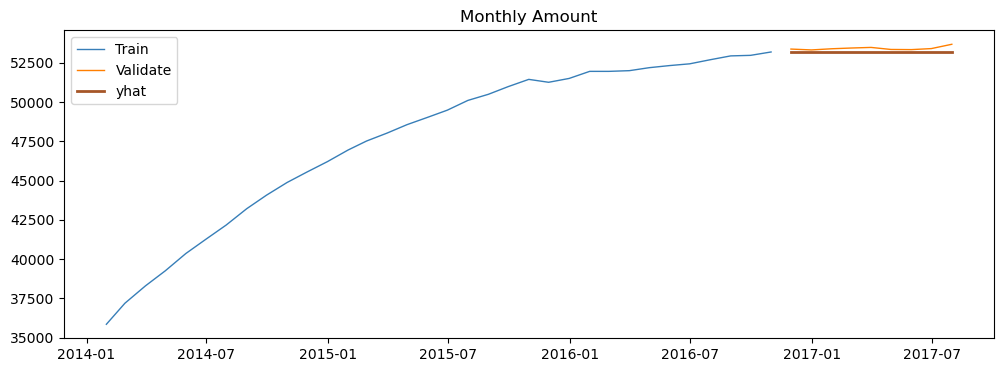

In [66]:
plot_and_eval('amount')

In [67]:
eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = 'amount')

eval_df

,model_type,target_var,rmse
0,last_observed_value,amount,253.0


# Simple Average 
   - Taling the mean and using that as the value we would have forever

In [69]:
avg_amount=round(train['amount'].mean(),2)
avg_amount

47597.21

In [72]:
def make_baseline_predictions(amount_prediction=None):
    yhat_df = pd.DataFrame({'amount': [amount_prediction]}, index=val.index)
    return yhat_df

In [73]:
yhat_df=make_baseline_predictions(avg_amount)
yhat_df.head()

,amount
date_invoiced,
2016-11-30,47597.21
2016-12-31,47597.21
2017-01-31,47597.21
2017-02-28,47597.21
2017-03-31,47597.21


amount -- RMSE: 5824


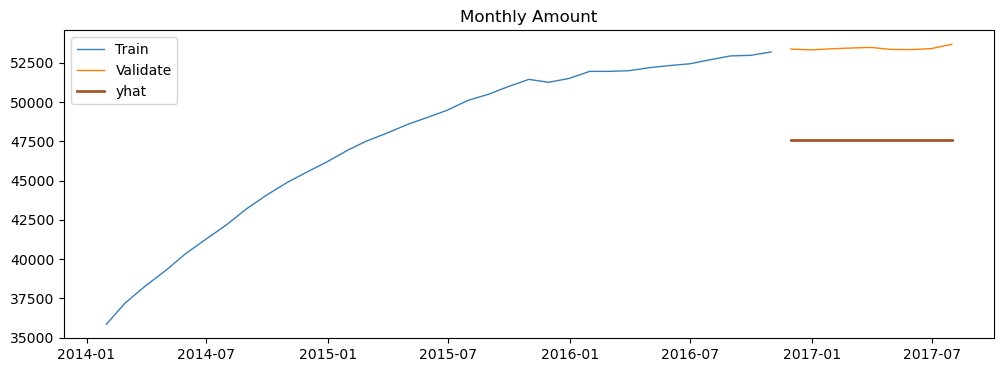

In [74]:
plot_and_eval('amount')

In [75]:
eval_df= append_eval_df(model_type='simple_average', target_var='amount')
eval_df

,model_type,target_var,rmse
0,last_observed_value,amount,253.0
1,simple_average,amount,5824.0


# Moving Average

In [77]:
period= 3
train['amount'].rolling(period).mean()[-1]

53035.0

In [78]:
rolling_amount = round(train['amount'].rolling(period).mean()[-1], 2)

print(rolling_amount)
51403.33
yhat_df = make_baseline_predictions(rolling_amount)
yhat_df.head()

53035.0


,amount
date_invoiced,
2016-11-30,53035.0
2016-12-31,53035.0
2017-01-31,53035.0
2017-02-28,53035.0
2017-03-31,53035.0


amount -- RMSE: 399


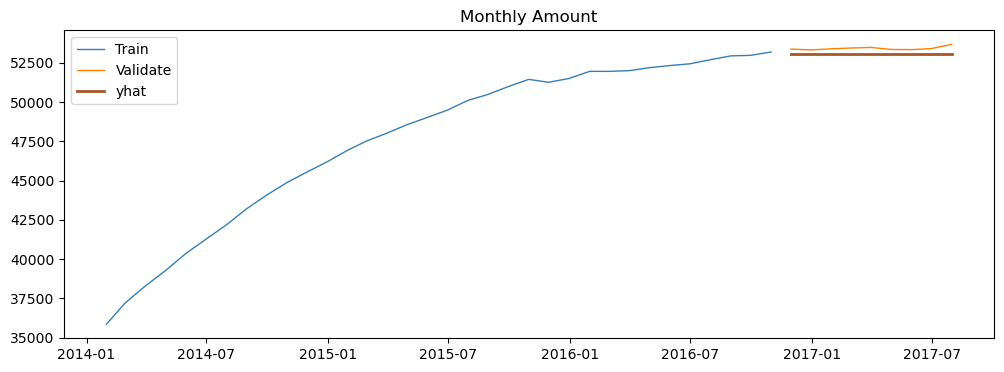

In [79]:
for col in train.columns:
    plot_and_eval(col)

In [80]:
for col in train.columns:
    eval_df = append_eval_df(model_type = '1Q_moving_avg', 
                            target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,amount,253.0
1,simple_average,amount,5824.0
2,1Q_moving_avg,amount,399.0


# Holts Winter

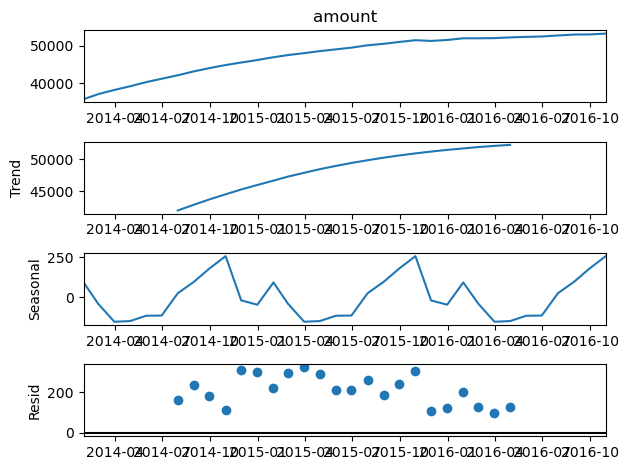

In [81]:
for col in train.columns:
    sm.tsa.seasonal_decompose(train[col].resample('M').mean()).plot()
    plt.show()

In [82]:
model = Holt(train['amount'], exponential=False, damped=True)
model = model.fit(optimized=True)

In [84]:
yhat_amount = model.predict(start = val.index[0],
                              end = val.index[-1])
val.shape

(9, 1)

In [85]:
yhat_amount

2016-11-30    53341.029681
2016-12-31    53499.657056
2017-01-31    53656.810818
2017-02-28    53812.504656
2017-03-31    53966.752132
2017-04-30    54119.566684
2017-05-31    54270.961621
2017-06-30    54420.950134
2017-07-31    54569.545285
Freq: M, dtype: float64

amount -- RMSE: 399


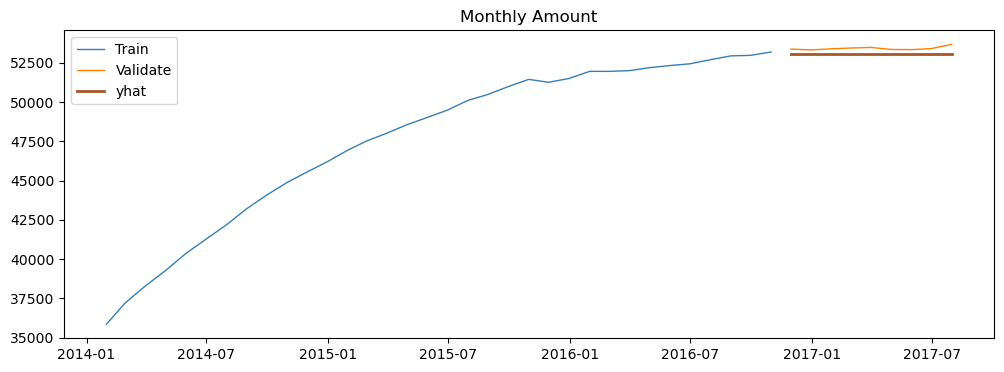

In [86]:
for col in train.columns:
    plot_and_eval(target_var = col)

In [87]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_optimized', 
                            target_var = col)
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
0,last_observed_value,amount,253.0
2,1Q_moving_avg,amount,399.0
3,holts_optimized,amount,399.0
1,simple_average,amount,5824.0
